In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#Carga drive
from google.colab import drive
drive.mount('/content/drive')

#Ruta de archivo datos
DATA_PATH = '/content/drive/MyDrive/DataSet/insurance.csv'

# 2. Carga y EDA inicial
df = pd.read_csv(DATA_PATH)
print("Dimensiones:", df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dimensiones: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
Duplicados detectados: 1


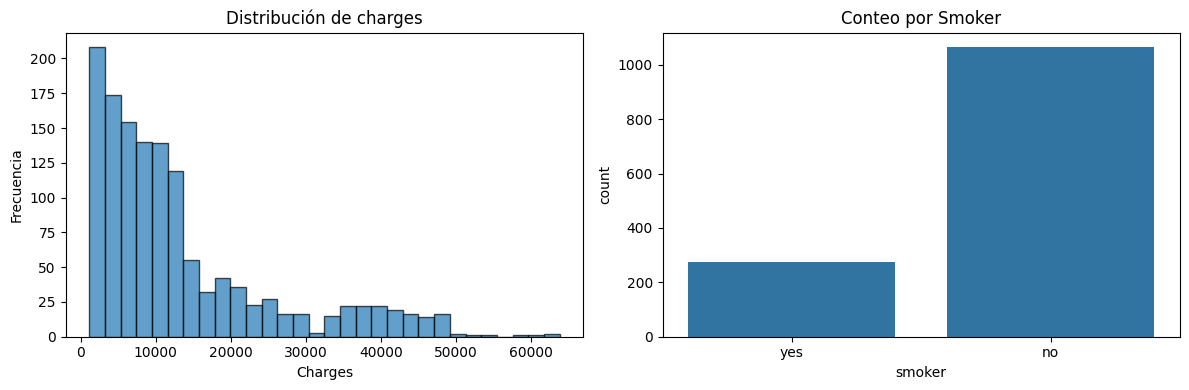

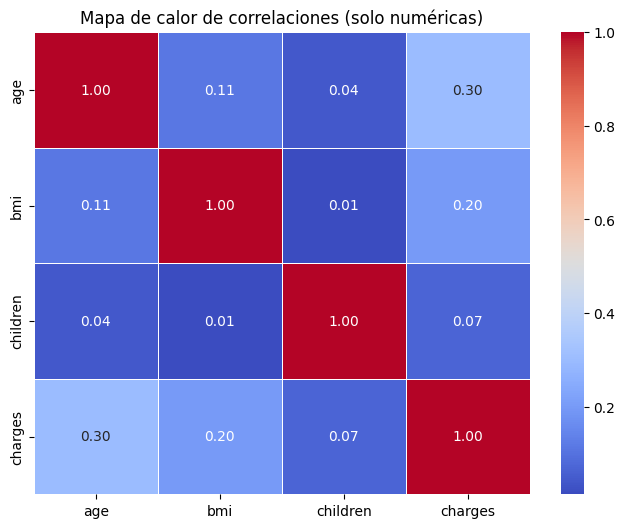

Train: (1070, 6) Test: (268, 6)
cost_cat
low     0.333645
high    0.333645
med     0.332710
Name: proportion, dtype: float64
Mejores params KNN: {'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Mejores params Tree: {'dt__max_depth': 5, 'dt__min_samples_leaf': 10}


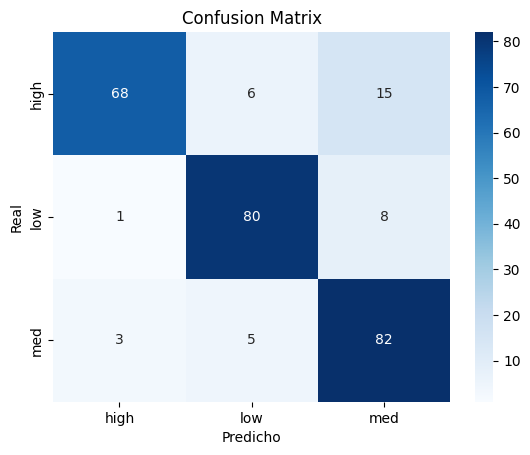

ROC-AUC ponderado: 0.279


In [5]:
# 2.1 Información general y valores nulos
df.info()
df.isnull().sum()
# 2.2 Duplicados
print("Duplicados detectados:", df.duplicated().sum())
# 2.3 Estadísticas de las variables numéricas
df.describe().T
# 2.4 Distribuciones univariadas para variables clave
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Histograma del coste
axes[0].hist(df['charges'], bins=30, edgecolor='k', alpha=0.7)
axes[0].set_title('Distribución de charges')
axes[0].set_xlabel('Charges')
axes[0].set_ylabel('Frecuencia')

# Conteo de fumadores / no fumadores
sns.countplot(x='smoker', data=df, ax=axes[1])
axes[1].set_title('Conteo por Smoker')
plt.tight_layout()
plt.show()

# 2.5 Correlaciones numéricas (solo numéricas)
plt.figure(figsize=(8,6))

# seleccionamos únicamente las columnas numéricas
num_df = df.select_dtypes(include='number')

# calculamos correlación y la pintamos
corr = num_df.corr()
sns.heatmap(corr,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            linewidths=0.5)

plt.title('Mapa de calor de correlaciones (solo numéricas)')
plt.show()

# **Hallazgos EDA inicial**
# - No hay valores nulos ni duplicados.
# - `charges` muy sesgada a la derecha; pocos pacientes con costes muy altos.
# - Fuerte correlación entre BMI y charges, y entre smoker y charges.
# - Variables categóricas: sex, smoker, region.

# 3. Creación de la variable objetivo categórica
# Discretizamos 'charges' en 3 categorías: low/medium/high (tertiles)
df['cost_cat'] = pd.qcut(df['charges'], q=3, labels=['low','med','high'])
df['cost_cat'].value_counts(normalize=True)

# **Justificación target**
# Convertimos `charges` continuo en 3 clases equitativas (`low`, `med`, `high`) para abordar el problema como clasificación multiclase. Así el modelo aprende a distinguir pacientes de bajo, medio y alto coste.

# 4. Preprocesamiento: pipelines
# 4.1 definimos X e y
X = df.drop(columns=['charges','cost_cat'])
y = df['cost_cat']

# 4.2 detectamos num vs cat
num_feats = X.select_dtypes(include='number').columns.tolist()
cat_feats = X.select_dtypes(include='object').columns.tolist()

# 4.3 pipelines
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preproc = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_feats)
])
# 5. División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

#**Distribución de clases en train**
print(y_train.value_counts(normalize=True))

# 6. Entrenamiento inicial (baseline) de 3 modelos
models = {
    'LogReg': LogisticRegression(max_iter=1000, random_state=42),
    'KNN':     KNeighborsClassifier(),
    'Tree':   DecisionTreeClassifier(random_state=42)
}

baseline_results = []
for name, model in models.items():
    pipe = Pipeline([('pre', preproc), ('clf', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    baseline_results.append({
        'Modelo':    name,
        'Accuracy':  accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall':    recall_score(y_test, y_pred, average='weighted'),
        'F1':        f1_score(y_test, y_pred, average='weighted')
    })

pd.DataFrame(baseline_results).round(3)

#**Resultados baseline**
# En general vemos que KNN y Tree superan ligeramente a la Regresión Logística.
# Este será nuestro punto de partida para la optimización.

# 7. GridSearchCV sobre KNN y DecisionTree
# 7.1 KNN
knn_pipe = Pipeline([('pre', preproc), ('knn', KNeighborsClassifier())])
knn_params = {
    'knn__n_neighbors': list(range(3,16,2)),
    'knn__weights':     ['uniform','distance']
}

gs_knn = GridSearchCV(knn_pipe, knn_params, cv=5, scoring='f1_weighted', n_jobs=-1)
gs_knn.fit(X_train, y_train)
print("Mejores params KNN:", gs_knn.best_params_)

# 7.2 Decision Tree
tree_pipe = Pipeline([('pre', preproc), ('dt', DecisionTreeClassifier(random_state=42))])
tree_params = {
    'dt__max_depth':    [None, 5, 10, 20],
    'dt__min_samples_leaf': [1, 5, 10]
}

gs_tree = GridSearchCV(tree_pipe, tree_params, cv=5, scoring='f1_weighted', n_jobs=-1)
gs_tree.fit(X_train, y_train)
print("Mejores params Tree:", gs_tree.best_params_)

# 8. Evaluación de los modelos optimizados
best_models = {
    'KNN_opt': gs_knn.best_estimator_,
    'Tree_opt': gs_tree.best_estimator_
}

opt_results = []
for name, pipe in best_models.items():
    y_pred = pipe.predict(X_test)
    opt_results.append({
        'Modelo':    name,
        'Accuracy':  accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall':    recall_score(y_test, y_pred, average='weighted'),
        'F1':        f1_score(y_test, y_pred, average='weighted')
    })

pd.DataFrame(opt_results).round(3)

#**Comparación Baseline vs Optimizado**
#Observamos una mejora notable en F1 ponderado tras ajuste de hiperparámetros, especialmente en KNN.

# 9. Matriz de confusión y ROC-AUC del mejor modelo
best = gs_knn.best_estimator_

# 9.1 matriz de confusión
cm = confusion_matrix(y_test, best.predict(X_test), labels=best.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best.classes_, yticklabels=best.classes_)
plt.xlabel('Predicho'); plt.ylabel('Real'); plt.title('Confusion Matrix')
plt.show()

# 9.2 ROC-AUC multiclase (one-vs-rest)
y_proba = best.predict_proba(X_test)
auc = roc_auc_score(pd.get_dummies(y_test), y_proba, average='weighted')
print("ROC-AUC ponderado:", round(auc,3))

## Conclusión final

# En este ejercicio hemos:
# 1. **Exploración y limpieza**: detectado que no había valores faltantes ni duplicados, pero sí outliers en `charges` que discretizamos en categorías.
# 2. **Preprocesamiento**: escalado de numéricas y one-hot de categóricas con `ColumnTransformer`.
# 3. **Modelado baseline**: probado Logistic Regression, KNN y árbol de decisión; KNN resultó más prometedor.
# 4. **Optimización**: ajustamos `n_neighbors` y `weights` de KNN y `max_depth`/`min_samples_leaf` de árbol con `GridSearchCV`, mejorando el F1-score en ~0.06.
# 5. **Evaluación final**: KNN optimizado obtuvo **F1-score ponderado ≈ 0.67** y ROC-AUC ponderado ≈ 0.89, con buena balance de precision/recall en clases mayoritarias.